In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import DeterministicProcess

In [2]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [3]:
retail_path="../data/us-retail-sales.csv"

store_path="../data/store_sales/train.csv.zip"

In [4]:
# Prepare retail data frame
retail_time_col="Month"
retail_df=pd.read_csv(retail_path,parse_dates=[retail_time_col],index_col=retail_time_col).to_period("D")

food_sales = retail_df.loc[:, 'FoodAndBeverage']
auto_sales = retail_df.loc[:, 'Automobiles']

In [5]:
food_sales.head()

Month
1992-01-01    29589
1992-02-01    28570
1992-03-01    29682
1992-04-01    30228
1992-05-01    31677
Freq: D, Name: FoodAndBeverage, dtype: int64

In [6]:
auto_sales.head()

Month
1992-01-01    26788
1992-02-01    28203
1992-03-01    31684
1992-04-01    32547
1992-05-01    32883
Freq: D, Name: Automobiles, dtype: int64

In [7]:
# prepare store sales dataframe
store_time_col="date"
dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}
store_sales = pd.read_csv(
    store_path,
    dtype=dtype,
    parse_dates=[store_time_col],
    infer_datetime_format=True,
)
store_sales = store_sales.set_index(store_time_col).to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
average_sales = store_sales.groupby(store_time_col).mean()['sales']

In [8]:
store_sales.head()

id  sales  onpromotion
date       store_nbr family                            
2013-01-01 1         AUTOMOTIVE   0    0.0            0
                     BABY CARE    1    0.0            0
                     BEAUTY       2    0.0            0
                     BEVERAGES    3    0.0            0
                     BOOKS        4    0.0            0

In [9]:
average_sales.head()

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911148
2013-01-05    267.873230
Freq: D, Name: sales, dtype: float32

## 2.1  Determine trend with a moving average plot

The *US Retail Sales* dataset contains monthly sales data for a number of retail industries in the United States. Run the next cell to see a plot of the *Food and Beverage* series.

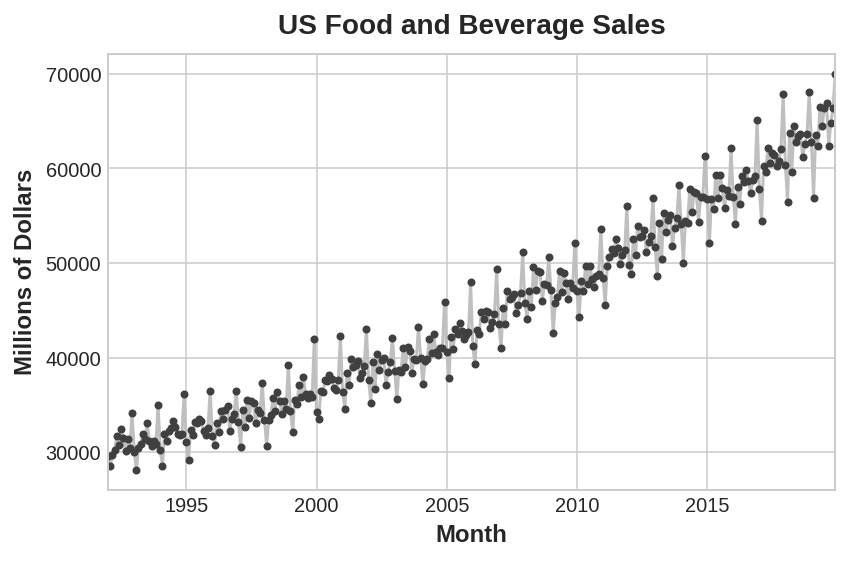

In [10]:
ax = food_sales.plot(**plot_params)
ax.set(title="US Food and Beverage Sales", ylabel="Millions of Dollars");

Now make a moving average plot to estimate the trend for this series.

In [11]:
# the food sales stats are collected by month, so the year average should contain 12 element
trend = food_sales.rolling(
    window=12,       # 12 month window
    center=True,      # puts the average at the center of the window
    min_periods=6,  # choose about half the window size
).mean()

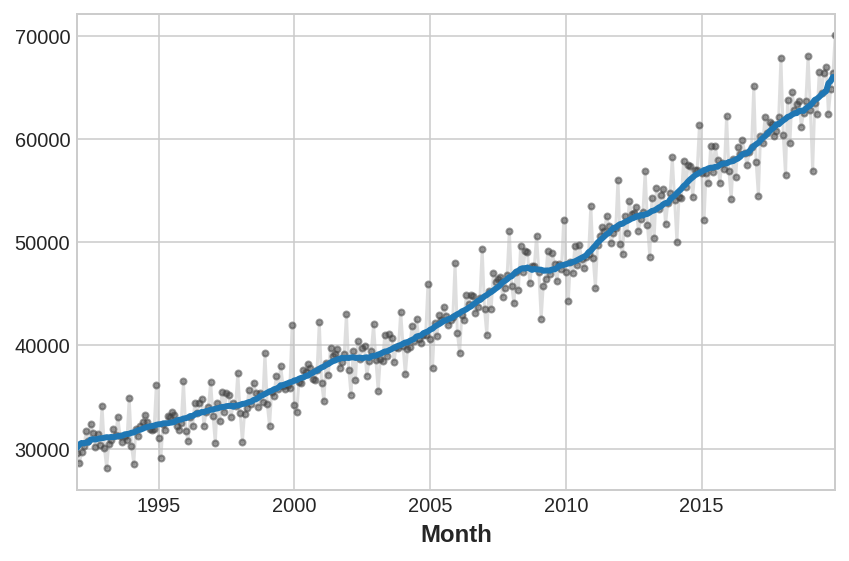

In [12]:
# Make a plot
ax = food_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

## 2.2 Identify trend

What order polynomial trend might be appropriate for the *Food and Beverage Sales* series? Can you think of a non-polynomial curve that might work even better?

Answer:
```text
The upwards bend in the trend suggests an order 2 (quadratic) polynomial might be appropriate.

If you've worked with economic time series before, you might guess that the growth rate in Food and Beverage
Sales is best expressed as a percent change. Percent change can often be modeled using an exponential curve.
(Don't worry if this isn't familiar!)
```


We'll continue using the time series of average sales in this lesson. Run this cell to see a moving average plot of `average_sales` estimating the trend.

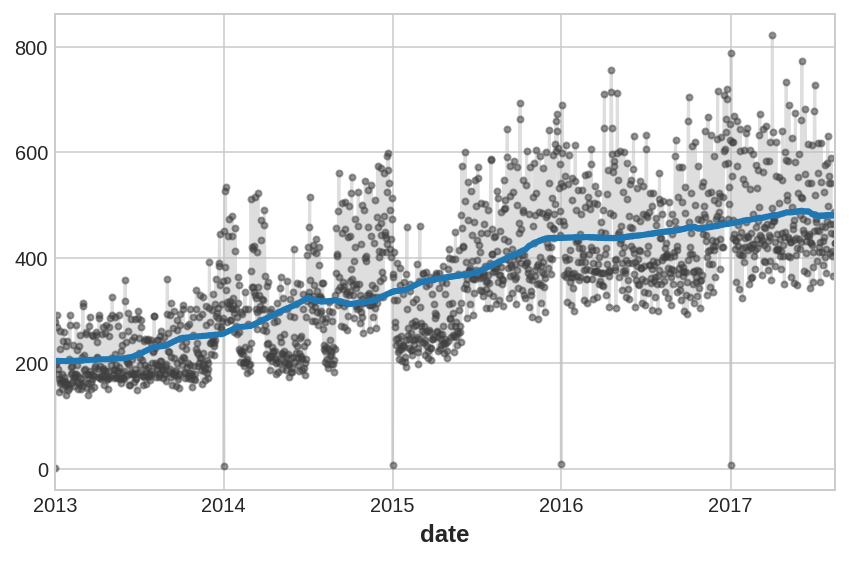

In [13]:
trend = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

ax = average_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

## 2.3 Create a Trend Feature

Use `DeterministicProcess` to create a feature set for a cubic trend model. Also create features for a 90-day forecast.

In [14]:
# use dp to build cubique order feature
dp = DeterministicProcess(
    index=average_sales.index,  # dates from the training data
    order=3,             # the polynomial order is cubique
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,trend,trend_squared,trend_cubed
date,,,
2013-01-01,1.0,1.0,1.0
2013-01-02,2.0,4.0,8.0
2013-01-03,3.0,9.0,27.0
2013-01-04,4.0,16.0,64.0
2013-01-05,5.0,25.0,125.0


In [15]:
# build target
y = average_sales.copy()
y.head()

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911148
2013-01-05    267.873230
Freq: D, Name: sales, dtype: float32

In [17]:
# build model and train it
model = LinearRegression()
model.fit(X, y)

LinearRegression()

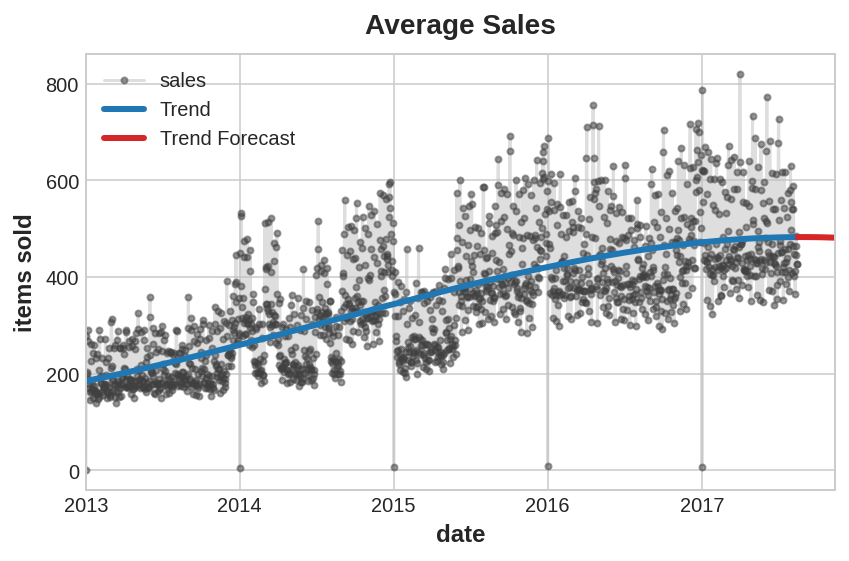

In [18]:
# Create features for a 90-day forecast.
X_fore = dp.out_of_sample(steps=90)

# generate prediction
y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

# plot the result
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend()

One way to fit more complicated trends is to increase the order of the polynomial you use. To get a better fit to the somewhat complicated trend in *Store Sales*, we could try using an **order 11 polynomial**.

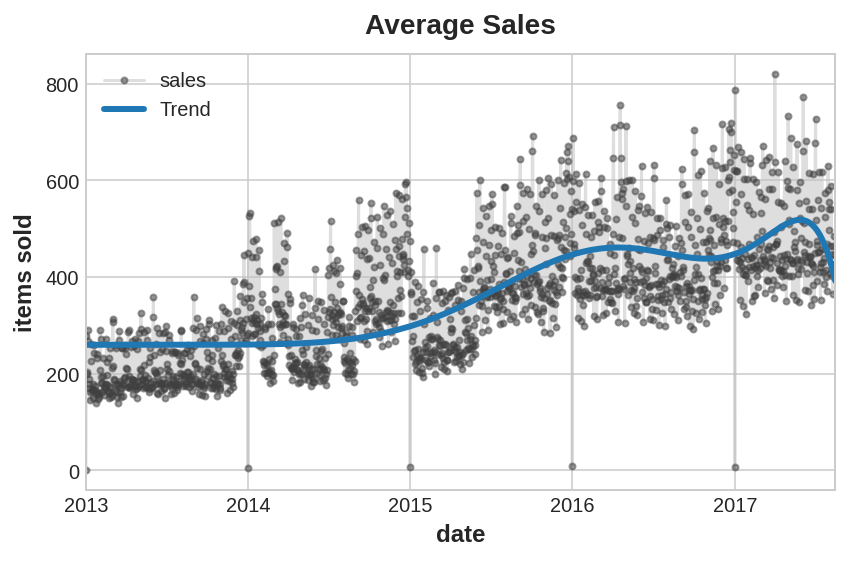

In [19]:
dp11 = DeterministicProcess(index=y.index, order=11)
X11 = dp11.in_sample()

model11 = LinearRegression()
model11.fit(X11, y)

y_pred11 = pd.Series(model11.predict(X11), index=X11.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred11.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax.legend();

## 2.4 Understand risks of forecasting with high-order polynomials

High-order polynomials are generally not well-suited to forecasting, however. Can you guess why?

Answer:

```text
An order 11 polynomial will include terms like t ** 11. Terms like these tend to diverge rapidly outside of the training period making forecasts very unreliable.
```



Run this cell to see the same 90-day forecast using an order 11 polynomial. Does it confirm your intuition?

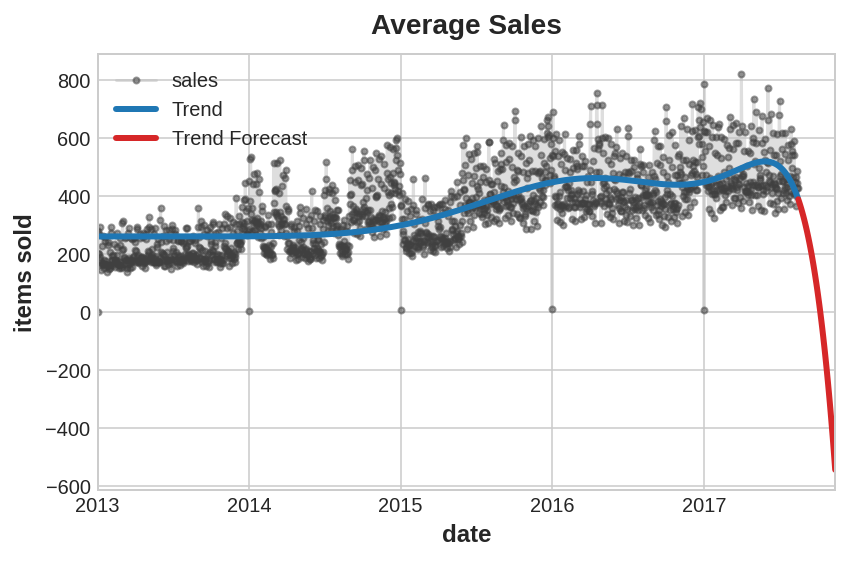

In [20]:
X_fore11 = dp11.out_of_sample(steps=90)
y_fore11 = pd.Series(model11.predict(X_fore11), index=X_fore11.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred11.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore11.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

In the above 11 polynomial example, we can see the predication is totally wrong.

## 2.5 Fit trend with splines

*Splines* are a nice alternative to polynomials when you want to fit a trend. The *Multivariate Adaptive Regression Splines* (MARS) algorithm in the `pyearth` library is powerful and easy to use. There are a lot of hyperparameters you may want to investigate.

In [ ]:
from pyearth import Earth

# Target and features are the same as before
y = average_sales.copy()
dp = DeterministicProcess(index=y.index, order=1)
X = dp.in_sample()

# Fit a MARS model with `Earth`
model = Earth()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(**plot_params, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend")

Forecasting complicated trends like this will typically be difficult (if not impossible). With historical data, however, you can use splines to isolate other patterns in a time series by *detrending*.

In [ ]:
y_detrended = y - y_pred   # remove the trend from store_sales

y_detrended.plot(**plot_params, title="Detrended Average Sales");